<center><img src="https://www.freewebheaders.com/wp-content/gallery/drinks/awesome-wine-barrel-and-bottle-with-red-wine-glasses-web-header.jpg" width=800 /></center>

# Project Goal

> Find drivers of wine quality and create a model that can accurately predict wine quality while performing better than baseline.

# Project Description

> Using the dataset for wine quality from [Data World](https://data.world/food/wine-quality), we looked for physicochemical properties that might have an effect on wine quality.

# Initial Hypotheses

> We believe that density, pH, alcohol, and sulphates will be the best predictors of wine quality.

# Project Plan

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import wrangle as w

import warnings
warnings.filterwarnings("ignore")

## Acquire

* Data acquired from Data World
* Combined both csv's and added additional column to include wine_type
* Each row represents a unique wine sample, its physicochemical properties, and its quality

In [2]:
wines = pd.read_csv('wines.csv')

In [3]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


## Prepare

* Verified datatypes
* Corrected column names
* No nulls present (yet)
* Visualized full dataset for univariate exploration
    * Handled outliers by removing top 1% of values in each column
* Split the data

In [4]:
wines = w.prepare_data(wines)

wines.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white


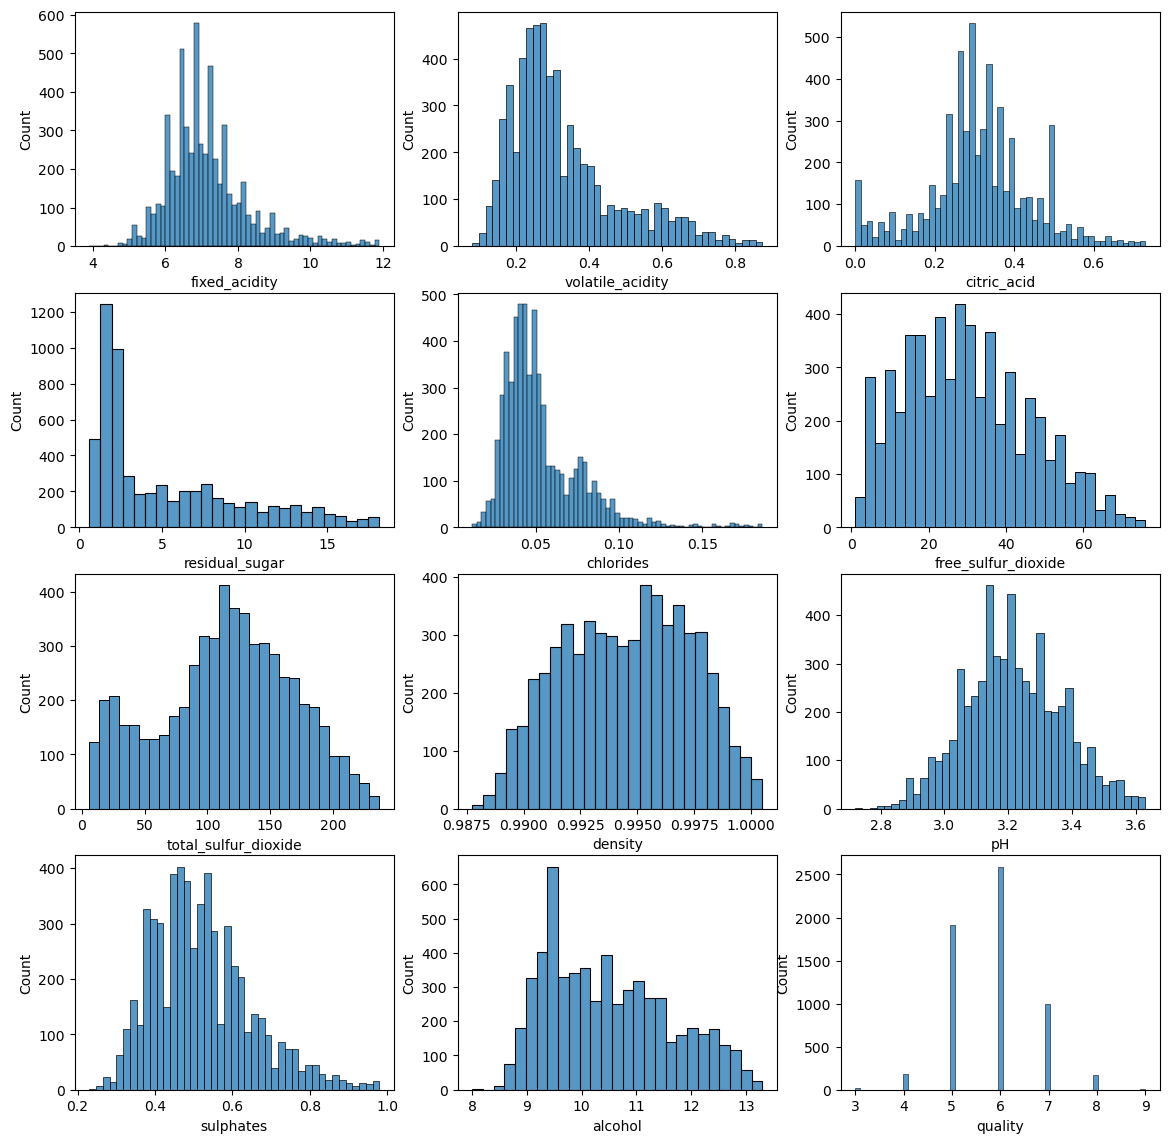

In [5]:
plt.figure(figsize=(14,14))

for i, col in enumerate(wines.drop(columns='wine_type')):
    plt.subplot(4,3,i+1)
    sns.histplot(wines[col])
    
plt.show()

In [6]:
wines.shape

(5871, 13)

In [7]:
train, validate, test = w.split_data(wines)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3522 entries, 1811 to 1290
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         3522 non-null   float64
 1   volatile_acidity      3522 non-null   float64
 2   citric_acid           3522 non-null   float64
 3   residual_sugar        3522 non-null   float64
 4   chlorides             3522 non-null   float64
 5   free_sulfur_dioxide   3522 non-null   float64
 6   total_sulfur_dioxide  3522 non-null   float64
 7   density               3522 non-null   float64
 8   pH                    3522 non-null   float64
 9   sulphates             3522 non-null   float64
 10  alcohol               3522 non-null   float64
 11  quality               3522 non-null   int64  
 12  wine_type             3522 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 385.2+ KB


## Explore

### Exploring effect of selected four variables to quality

$H_0$: There is no correlation between our selected features (density, pH, alcohol, sulphates) and our target variable (quality).

$H_\alpha$: There is a correlation between our selected features and our target variable (quality).

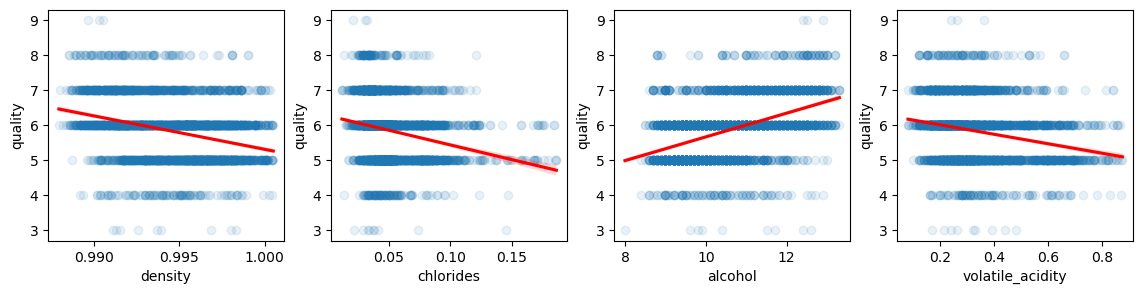

In [9]:
plt.figure(figsize=(14,3))

for i, col in enumerate(train[['density', 'chlorides', 'alcohol', 'volatile_acidity', 'quality']]):
    if col != 'quality':
        plt.subplot(1, 4, i+1)
        sns.regplot(data = train, x = col, y = 'quality', scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'})

plt.show()

In [10]:
corr_df = w.correlation_tests(train[['density', 'chlorides', 'alcohol', 'volatile_acidity', 'wine_type', 'quality']])

corr_df

,feature,r,p
4,quality,1.000000,0.000000e+00
2,alcohol,0.455295,8.087609e-180
0,density,0.310984,7.757551e-80
3,volatile_acidity,0.233614,7.267833e-45
1,chlorides,0.229236,3.205283e-43


Among all twelve features, alcohol, density, volatile_acidity, and chlorides had the highest correlation with wine quality. We will keep that in mind as we move into exploring clusters.

### What clusters are useful?

We created visualizations for iterations of all the numeric columns and split quality into two bins (good and bad). Of the 55 graphs we looked at, we isolated the three below that show distinct clusters.

* Bad = 3-5
* Good = 6

In [11]:
train['quality_bin'] = pd.qcut(train.quality, q=3, labels=['low','mid','high'])

In [12]:
train['quality_bin'] = np.where(train['quality_bin'] == 'low', 'bad', 'good')

In [13]:
train.quality_bin.value_counts()

good    2254
bad     1268
Name: quality_bin, dtype: int64

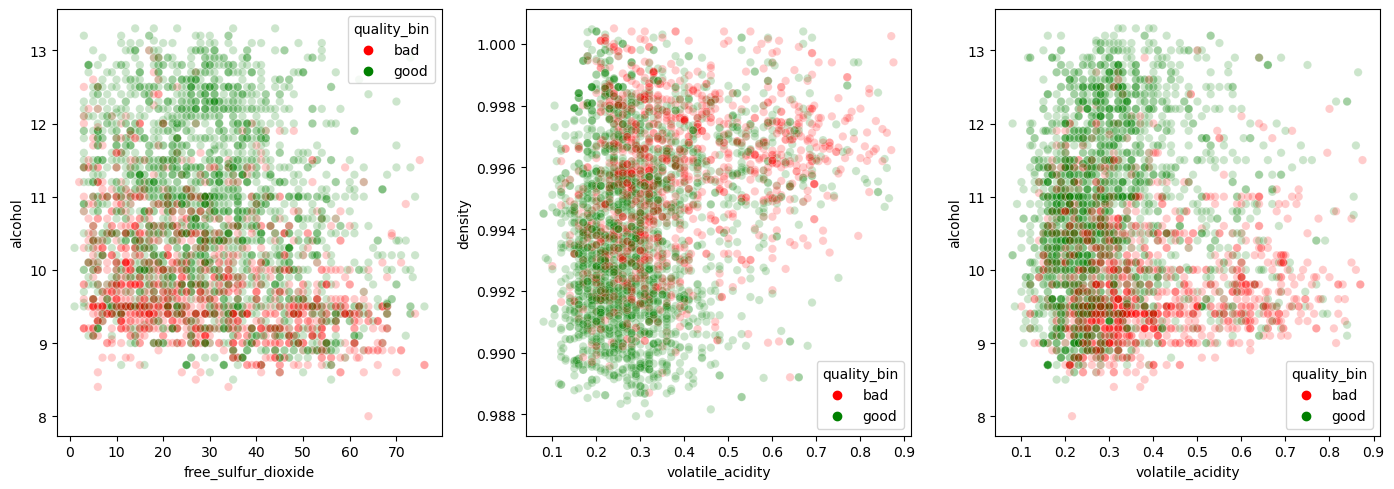

In [14]:
c_list = ['red', 'green']

plt.figure(figsize=(14,5))

plt.subplot(131)
sns.scatterplot(data=train, x='free_sulfur_dioxide', y='alcohol', hue='quality_bin', palette=c_list, alpha=0.2)

plt.subplot(132)
sns.scatterplot(data=train, x='volatile_acidity', y='density', hue='quality_bin', palette=c_list, alpha=0.2)

plt.subplot(133)
sns.scatterplot(data=train, x='volatile_acidity', y='alcohol', hue='quality_bin', palette=c_list, alpha=0.2)

plt.tight_layout()
plt.show()

Created clusters for density vs. volatile acidity and alcohol vs. volatile acidity.

In [15]:
train_scaled, validate_scaled, test_scaled =  w.scale_data(train, validate, test, 
        cols=train.iloc[:, 0:11].columns)

train_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin
1811,0.441558,0.377358,0.273973,0.159544,0.195402,0.106667,0.478261,0.514331,0.472527,0.219178,0.264151,5,white,bad
3551,0.194805,0.176101,0.301370,0.914530,0.183908,0.506667,0.452174,0.844745,0.571429,0.315068,0.188679,6,white,good
3338,0.389610,0.238994,0.383562,0.831909,0.195402,0.066667,0.152174,0.693471,0.494505,0.191781,0.547170,6,white,good
1475,0.389610,0.000000,0.671233,0.039886,0.218391,0.226667,0.617391,0.522293,0.813187,0.260274,0.415094,6,white,good
184,0.337662,0.226415,0.767123,0.643875,0.178161,0.840000,0.956522,0.721338,0.329670,0.520548,0.245283,5,white,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,0.246753,0.251572,0.369863,0.233618,0.103448,0.733333,0.582609,0.197452,0.483516,0.232877,0.849057,8,white,good
740,0.350649,0.389937,0.547945,0.227920,0.057471,0.053333,0.056522,0.283439,0.648352,0.164384,0.867925,3,white,bad
628,0.363636,0.301887,0.328767,0.319088,0.206897,0.400000,0.965217,0.617834,0.560440,0.506849,0.264151,6,white,good
1597,0.285714,0.238994,0.671233,0.381766,0.195402,0.693333,0.869565,0.609873,0.571429,0.246575,0.226415,6,white,good


In [16]:
validate_scaled['quality_bin'] = pd.qcut(validate_scaled.quality, q=3, labels=['low','mid','high'])
validate_scaled['quality_bin'] = np.where(validate_scaled['quality_bin'] == 'low', 'bad', 'good')

In [17]:
test_scaled['quality_bin'] = pd.qcut(test_scaled.quality, q=3, labels=['low','mid','high'])
test_scaled['quality_bin'] = np.where(test_scaled['quality_bin'] == 'low', 'bad', 'good')

In [18]:
train_scaled.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin
1811,0.441558,0.377358,0.273973,0.159544,0.195402,0.106667,0.478261,0.514331,0.472527,0.219178,0.264151,5,white,bad
3551,0.194805,0.176101,0.301370,0.914530,0.183908,0.506667,0.452174,0.844745,0.571429,0.315068,0.188679,6,white,good
3338,0.389610,0.238994,0.383562,0.831909,0.195402,0.066667,0.152174,0.693471,0.494505,0.191781,0.547170,6,white,good
1475,0.389610,0.000000,0.671233,0.039886,0.218391,0.226667,0.617391,0.522293,0.813187,0.260274,0.415094,6,white,good
184,0.337662,0.226415,0.767123,0.643875,0.178161,0.840000,0.956522,0.721338,0.329670,0.520548,0.245283,5,white,bad


In [19]:
from sklearn.cluster import KMeans

X = train_scaled[['volatile_acidity', 'density']]

kmeans = KMeans(n_clusters=2
                , init = np.array([[0.2,0.6], [0.5,0.6]], np.float64)
                , max_iter=1
               )
kmeans.fit(X)
train_scaled['va_d'] = kmeans.predict(X)
train_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin,va_d
1811,0.441558,0.377358,0.273973,0.159544,0.195402,0.106667,0.478261,0.514331,0.472527,0.219178,0.264151,5,white,bad,0
3551,0.194805,0.176101,0.301370,0.914530,0.183908,0.506667,0.452174,0.844745,0.571429,0.315068,0.188679,6,white,good,0
3338,0.389610,0.238994,0.383562,0.831909,0.195402,0.066667,0.152174,0.693471,0.494505,0.191781,0.547170,6,white,good,0
1475,0.389610,0.000000,0.671233,0.039886,0.218391,0.226667,0.617391,0.522293,0.813187,0.260274,0.415094,6,white,good,0
184,0.337662,0.226415,0.767123,0.643875,0.178161,0.840000,0.956522,0.721338,0.329670,0.520548,0.245283,5,white,bad,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,0.246753,0.251572,0.369863,0.233618,0.103448,0.733333,0.582609,0.197452,0.483516,0.232877,0.849057,8,white,good,0
740,0.350649,0.389937,0.547945,0.227920,0.057471,0.053333,0.056522,0.283439,0.648352,0.164384,0.867925,3,white,bad,0
628,0.363636,0.301887,0.328767,0.319088,0.206897,0.400000,0.965217,0.617834,0.560440,0.506849,0.264151,6,white,good,0
1597,0.285714,0.238994,0.671233,0.381766,0.195402,0.693333,0.869565,0.609873,0.571429,0.246575,0.226415,6,white,good,0


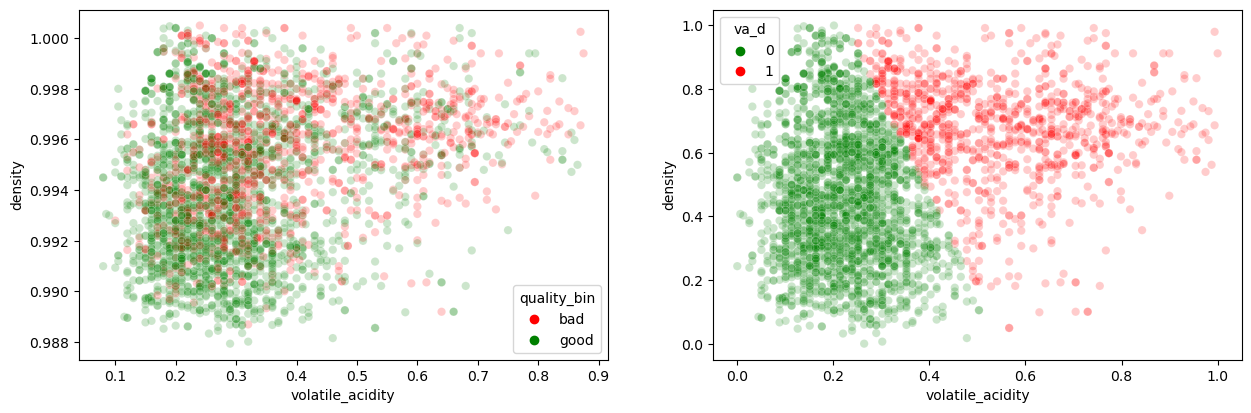

In [20]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.scatterplot(data=train, x='volatile_acidity', y='density', hue='quality_bin', palette=c_list, alpha=0.2)

plt.subplot(2,2,2)
sns.scatterplot(data=train_scaled, x='volatile_acidity', y='density', hue='va_d', palette= ['green', 'red'], alpha=0.2)

plt.show()

In [21]:
X = train_scaled[['volatile_acidity', 'alcohol']]

kmeans = KMeans(n_clusters=2
                , init = np.array([[0.05,0.45], [0.2,0.2]], np.float64)
                , max_iter=1
               )
kmeans.fit(X)
train_scaled['va_a'] = kmeans.predict(X)
train_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin,va_d,va_a
1811,0.441558,0.377358,0.273973,0.159544,0.195402,0.106667,0.478261,0.514331,0.472527,0.219178,0.264151,5,white,bad,0,1
3551,0.194805,0.176101,0.301370,0.914530,0.183908,0.506667,0.452174,0.844745,0.571429,0.315068,0.188679,6,white,good,0,1
3338,0.389610,0.238994,0.383562,0.831909,0.195402,0.066667,0.152174,0.693471,0.494505,0.191781,0.547170,6,white,good,0,0
1475,0.389610,0.000000,0.671233,0.039886,0.218391,0.226667,0.617391,0.522293,0.813187,0.260274,0.415094,6,white,good,0,0
184,0.337662,0.226415,0.767123,0.643875,0.178161,0.840000,0.956522,0.721338,0.329670,0.520548,0.245283,5,white,bad,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,0.246753,0.251572,0.369863,0.233618,0.103448,0.733333,0.582609,0.197452,0.483516,0.232877,0.849057,8,white,good,0,0
740,0.350649,0.389937,0.547945,0.227920,0.057471,0.053333,0.056522,0.283439,0.648352,0.164384,0.867925,3,white,bad,0,0
628,0.363636,0.301887,0.328767,0.319088,0.206897,0.400000,0.965217,0.617834,0.560440,0.506849,0.264151,6,white,good,0,1
1597,0.285714,0.238994,0.671233,0.381766,0.195402,0.693333,0.869565,0.609873,0.571429,0.246575,0.226415,6,white,good,0,1


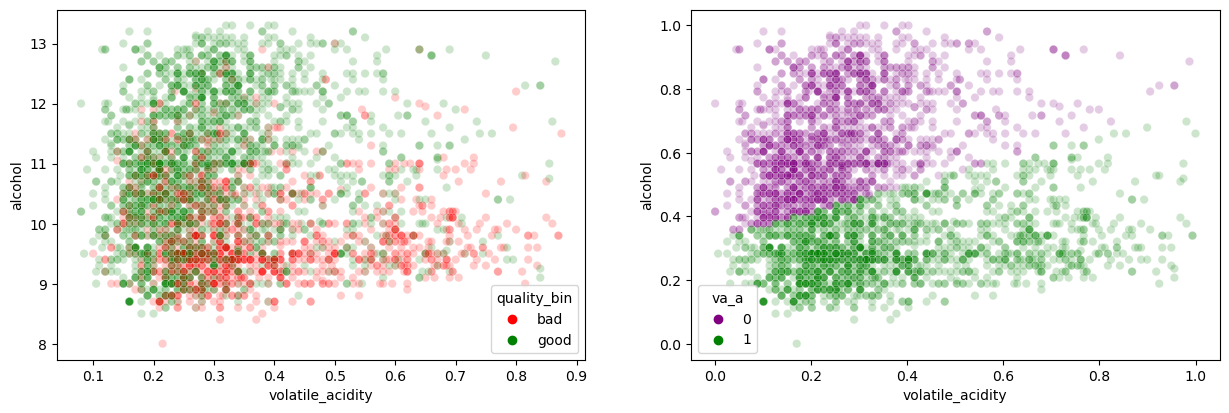

In [22]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.scatterplot(data=train, x='volatile_acidity', y='alcohol', hue='quality_bin', palette=c_list, alpha=0.2)

plt.subplot(2,2,2)
sns.scatterplot(data=train_scaled, x='volatile_acidity', y='alcohol', hue='va_a', palette= ['purple', 'green'], alpha=0.2)

plt.show()

In [23]:
from sklearn.cluster import KMeans

X = train_scaled[['free_sulfur_dioxide', 'alcohol']]

kmeans = KMeans(n_clusters=2
                , init = np.array([[0.3,0.3], [0.5,0.6]], np.float64)
                , max_iter=1
               )
kmeans.fit(X)
train_scaled['fsd_a'] = kmeans.predict(X)
train_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin,va_d,va_a,fsd_a
1811,0.441558,0.377358,0.273973,0.159544,0.195402,0.106667,0.478261,0.514331,0.472527,0.219178,0.264151,5,white,bad,0,1,0
3551,0.194805,0.176101,0.301370,0.914530,0.183908,0.506667,0.452174,0.844745,0.571429,0.315068,0.188679,6,white,good,0,1,0
3338,0.389610,0.238994,0.383562,0.831909,0.195402,0.066667,0.152174,0.693471,0.494505,0.191781,0.547170,6,white,good,0,0,0
1475,0.389610,0.000000,0.671233,0.039886,0.218391,0.226667,0.617391,0.522293,0.813187,0.260274,0.415094,6,white,good,0,0,0
184,0.337662,0.226415,0.767123,0.643875,0.178161,0.840000,0.956522,0.721338,0.329670,0.520548,0.245283,5,white,bad,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,0.246753,0.251572,0.369863,0.233618,0.103448,0.733333,0.582609,0.197452,0.483516,0.232877,0.849057,8,white,good,0,0,1
740,0.350649,0.389937,0.547945,0.227920,0.057471,0.053333,0.056522,0.283439,0.648352,0.164384,0.867925,3,white,bad,0,0,1
628,0.363636,0.301887,0.328767,0.319088,0.206897,0.400000,0.965217,0.617834,0.560440,0.506849,0.264151,6,white,good,0,1,0
1597,0.285714,0.238994,0.671233,0.381766,0.195402,0.693333,0.869565,0.609873,0.571429,0.246575,0.226415,6,white,good,0,1,0


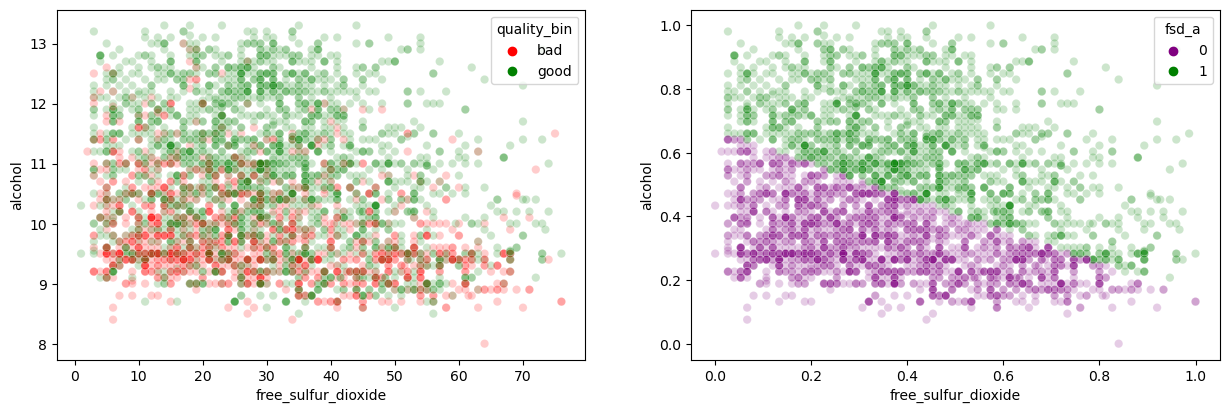

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
sns.scatterplot(data=train, x='free_sulfur_dioxide', y='alcohol', hue='quality_bin', palette=c_list, alpha=0.2)

plt.subplot(2,2,2)
sns.scatterplot(data=train_scaled, x='free_sulfur_dioxide', y='alcohol', hue='fsd_a', palette= ['purple', 'green'], alpha=0.2)

plt.show()

In [25]:
train_scaled.quality_bin.value_counts()

good    2254
bad     1268
Name: quality_bin, dtype: int64

In [26]:
2254/(2254+1268)

0.639977285633163

$H_0$: There is no difference in the means of the clustered sets amongst each other for quality.

$H_\alpha$: There is a difference in the means of the clusters sets amongst each other for quality.

In [27]:
l_of_l = [['va_a', 'quality_bin'], ['va_d', 'quality_bin'], ['fsd_a', 'quality_bin']]

w.chi2_test(train_scaled, l_of_l)

,feature,chi2,p,degf,expected
1,"[va_a, quality_bin]",575.314019,3.920884e-127,1,"[[615.9988642816581, 1095.0011357183419], [652..."
2,"[va_d, quality_bin]",254.719868,2.429425e-57,1,"[[903.2969903463941, 1605.703009653606], [364...."
3,"[fsd_a, quality_bin]",499.438983,1.259031e-110,1,"[[670.7223168654174, 1192.2776831345827], [597..."


Ran ANOVA tests on the three clusters towards target variable to select best clustering to send into our model.

In [28]:
# train = w.get_dummies_and_hot_encoded(train)
# validate = w.get_dummies_and_hot_encoded(validate)
# test = w.get_dummies_and_hot_encoded(test)

# means_df = w.comparison_of_means(train)

In [29]:
#means_df

The cluster with the lowest p-value was the volatile acidity and the alcohol combination. We will proceed with this cluster.

In [30]:
# plt.figure(figsize=(14,5))

# plt.subplot(131)
# sns.barplot(data=train, x='cluster_fix_vol_acid', y='quality')

# plt.subplot(132)
# sns.barplot(data=train, x='cluster_cit_acd_res_sug', y='quality')

# plt.subplot(133)
# sns.barplot(data=train, x='cluster_clorid_diox', y='quality')

# plt.show()

### Exploration Summary

* Predicting quality is easier when binned into two bins of "good" vs. "bad" wines.
* Of all physicochemical properties, alcohol, density, volatile_acidity, and chlorides were the properties with the highest correlation with quality.
* Of the 55 graphs that we looked through, the features volatile_acidity, alcohol, density, and free_sulfur_dioxide had the most visible clusters.
* Of the 3 graphs that we proceeded with, the combination of alcohol and volatile acidity had the best accuracy of good vs. bad wines.
* We will proceed with feeding the cluster of alcohol + volatile_acidity into the model, as well as the independent variables of density and chlorides.

## Modeling

### Scaling on selected features

In [31]:
train_scaled.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin,va_d,va_a,fsd_a
1811,0.441558,0.377358,0.273973,0.159544,0.195402,0.106667,0.478261,0.514331,0.472527,0.219178,0.264151,5,white,bad,0,1,0
3551,0.194805,0.176101,0.301370,0.914530,0.183908,0.506667,0.452174,0.844745,0.571429,0.315068,0.188679,6,white,good,0,1,0
3338,0.389610,0.238994,0.383562,0.831909,0.195402,0.066667,0.152174,0.693471,0.494505,0.191781,0.547170,6,white,good,0,0,0
1475,0.389610,0.000000,0.671233,0.039886,0.218391,0.226667,0.617391,0.522293,0.813187,0.260274,0.415094,6,white,good,0,0,0
184,0.337662,0.226415,0.767123,0.643875,0.178161,0.840000,0.956522,0.721338,0.329670,0.520548,0.245283,5,white,bad,0,1,1


In [32]:
train_scaled, validate_scaled, test_scaled = w.get_cluster_columns(train_scaled, validate_scaled, test_scaled, 
                                                                   features_list = [['volatile_acidity', 'alcohol']]
                      , clusters=2
                     , init_array = np.array([[0.05,0.45], [0.2,0.2]], np.float64)
                     , iterations = 1)

In [33]:
train_scaled.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin,va_d,va_a,fsd_a,volatile_acidity_alcohol
1811,0.441558,0.377358,0.273973,0.159544,0.195402,0.106667,0.478261,0.514331,0.472527,0.219178,0.264151,5,white,bad,0,1,0,1
3551,0.194805,0.176101,0.301370,0.914530,0.183908,0.506667,0.452174,0.844745,0.571429,0.315068,0.188679,6,white,good,0,1,0,1
3338,0.389610,0.238994,0.383562,0.831909,0.195402,0.066667,0.152174,0.693471,0.494505,0.191781,0.547170,6,white,good,0,0,0,0
1475,0.389610,0.000000,0.671233,0.039886,0.218391,0.226667,0.617391,0.522293,0.813187,0.260274,0.415094,6,white,good,0,0,0,0
184,0.337662,0.226415,0.767123,0.643875,0.178161,0.840000,0.956522,0.721338,0.329670,0.520548,0.245283,5,white,bad,0,1,1,1


In [34]:
features = ['volatile_acidity_alcohol', 'chlorides', 'density']

X_train = train_scaled[features]
y_train = train_scaled.quality_bin

X_validate = validate_scaled[features]
y_validate = validate_scaled.quality_bin

X_test = test_scaled[features]
y_test = test_scaled.quality_bin

In [35]:
w.create_knn(X_train,y_train, X_validate, y_validate)

,model_train,train_predict,validate_predict,n_neighbors
0,knn,0.639977,0.639977,neighbors
1,KNeighborsClassifier,0.975298,0.727428,1
2,KNeighborsClassifier,0.853776,0.661840,2
3,KNeighborsClassifier,0.838160,0.705281,3
4,KNeighborsClassifier,0.791596,0.686542,4
5,KNeighborsClassifier,0.784214,0.706985,5
6,KNeighborsClassifier,0.770585,0.685690,6
7,KNeighborsClassifier,0.769165,0.704429,7
8,KNeighborsClassifier,0.759228,0.695060,8
9,KNeighborsClassifier,0.757240,0.701022,9


In [36]:
w.create_logistic_regression(X_train,y_train, X_validate, y_validate)

,model_train,train_predict,validate_predict,C
0,knn,0.639977,0.639977,the_c
1,LogisticRegression,0.662124,0.656729,0.01
2,LogisticRegression,0.686542,0.667802,0.1
3,LogisticRegression,0.687961,0.670358,1
4,LogisticRegression,0.689097,0.672061,10
5,LogisticRegression,0.688813,0.672061,100
6,LogisticRegression,0.688529,0.672061,1000


In [37]:
w.create_random_forest(X_train,y_train, X_validate, y_validate)

,model_train,train_predict,validate_predict,max_depth
0,knn,0.639977,0.639977,max_depth
1,RandomForestClassifier,0.639977,0.658433,1
2,RandomForestClassifier,0.682851,0.668654,2
3,RandomForestClassifier,0.706417,0.702726,3
4,RandomForestClassifier,0.719761,0.712095,4
5,RandomForestClassifier,0.731119,0.724020,5
6,RandomForestClassifier,0.747303,0.724020,6
7,RandomForestClassifier,0.767178,0.728279,7
8,RandomForestClassifier,0.785917,0.736797,8
9,RandomForestClassifier,0.814310,0.735945,9


In [38]:
w.create_descision_tree(X_train,y_train, X_validate, y_validate)

,model_train,train_predict,validate_predict,max_depth
0,knn,0.639977,0.639977,max_depth
1,DecisionTreeClassifier,0.690233,0.668654,1
2,DecisionTreeClassifier,0.690233,0.668654,2
3,DecisionTreeClassifier,0.702442,0.694208,3
4,DecisionTreeClassifier,0.703294,0.694208,4
5,DecisionTreeClassifier,0.713515,0.693356,5
6,DecisionTreeClassifier,0.725156,0.706985,6
7,DecisionTreeClassifier,0.737933,0.702726,7
8,DecisionTreeClassifier,0.756104,0.701022,8
9,DecisionTreeClassifier,0.778535,0.692504,9


In [39]:
w.super_classification_model(X_train,y_train, X_validate, y_validate, the_c = 1)

,model_train,train_predict,validate_predict
0,baseline,0.639977,0.639977
1,KNeighborsClassifier,0.718626,0.700170
2,LogisticRegression,0.687961,0.670358
3,RandomForestClassifier,0.976434,0.738501
4,DecisionTreeClassifier,0.702442,0.694208


In [40]:
#train_scaled, validate_scaled, test_scaled =  w.scale_data(train, validate, test)

In [41]:
#train_scaled.head()

In [42]:
#X_train, X_validate, X_test, y_train, y_validate, y_test = w.mvp_info(train_scaled, validate_scaled, test_scaled)

In [43]:
#X_train.head()

In [44]:
#metrics_train_df, metrics_validate_df, metrics_test_df= w.get_model_numbers(X_train, X_validate, X_test, y_train, y_validate, y_test)

In [45]:
#metrics_train_df

In [46]:
#metrics_validate_df

In [47]:
#metrics_test_df

### Modeling Summary

* GLM performed the best

## Conclusion

* Since the top model only performend with an R2 score of 0.22, we cannot move forward with it.
* Solution would be to continue onto next steps in hopes of creating a better model.

# Next Steps

* Look over different sets of clusters among the wine data by going over iterations of the data.
* Find other independent variables that affect the target variable.